Starting Antithetic Correlation Analysis for: batch_20251112_19-11-56

Processing Configuration: random_20N / stable
  Found 500 standard runs. Searching for pairs...

------------------------------
Correlation Analysis (PDR)
  (Based on 500 antithetic pairs)
  Correlation (r): -0.089092
  Mean Standard PDR:   0.7167
  Mean Antithetic PDR: 0.7236
  Mean Paired PDR:     0.7201
  StdDev Standard PDR:   0.2262
  StdDev Antithetic PDR: 0.2124
  StdDev Paired PDR:     0.1482 <-- This should be smallest!
------------------------------


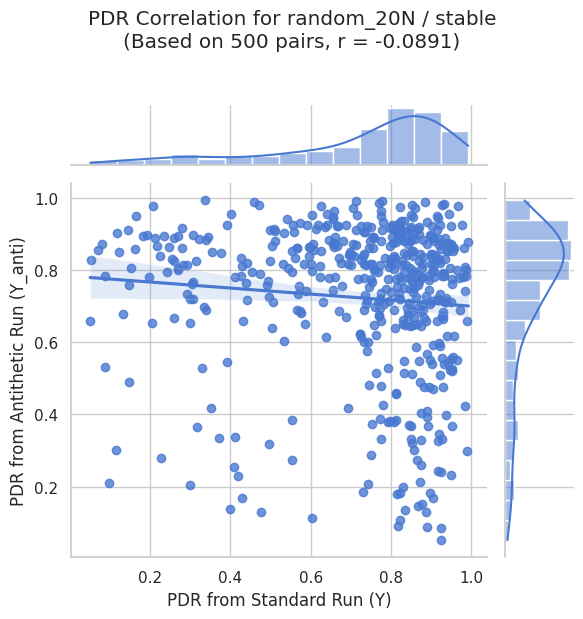



Antithetic analysis complete.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

PATH_TO_RESULTS_BATCH_FOLDER = Path("/home/damole/Documents/develop/SPE-project/results/batch_20251112_19-11-56/")


# Log file names
PDR_LOG_FILE = "log_PDR.csv"
LATENCY_LOG_FILE = "log_e2eLat.csv"

sns.set(style="whitegrid", palette="muted")
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

def process_pdr_file(file_path):

    try:
        df_pdr = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_pdr.empty:

            return 0.0 
        
        if 'delivered' not in df_pdr.columns:
            print(f"  - ERROR: 'delivered' column not found in: {file_path}", file=sys.stderr)
            return None
            
        # The 'delivered' column is 0 or 1. The mean is the PDR.
        run_pdr = df_pdr['delivered'].mean()
        return run_pdr
    
    except FileNotFoundError:
        print(f"  - WARNING: PDR file not found, skipping: {file_path}", file=sys.stderr)
        return None
    except pd.errors.EmptyDataError:
        # File exists but is empty. Treat as PDR 0.0
        return 0.0
    except Exception as e:
        print(f"  - ERROR processing PDR file {file_path}: {e}", file=sys.stderr)
        return None


if not PATH_TO_RESULTS_BATCH_FOLDER.is_dir():
    print(f"ERROR: Batch directory not found at: {PATH_TO_RESULTS_BATCH_FOLDER}", file=sys.stderr)
    print("Please check your 'PATH_TO_RESULTS_BATCH_FOLDER' variable.", file=sys.stderr)
else:
    print(f"Starting Antithetic Correlation Analysis for: {PATH_TO_RESULTS_BATCH_FOLDER.name}\n")
    
    # Find topology folders
    topo_dirs = sorted([d for d in PATH_TO_RESULTS_BATCH_FOLDER.iterdir() if d.is_dir()])
    
    if not topo_dirs:
        print(f"  No topology folders found in {PATH_TO_RESULTS_BATCH_FOLDER}", file=sys.stderr)

    # --- Iterate over each Topology ---
    for topo_dir in topo_dirs:
        
        # Find channel folders (e.g., 'stable', 'lossy')
        channel_dirs = sorted([d for d in topo_dir.iterdir() if d.is_dir()])
        
        if not channel_dirs:
            print(f"  No channel folders found in {topo_dir}", file=sys.stderr)
            continue
            
        # --- Iterate over each Channel Configuration ---
        for channel_dir in channel_dirs:
            config_name = f"{topo_dir.name} / {channel_dir.name}"
            print("="*70)
            print(f"Processing Configuration: {config_name}")
            print("="*70)

            # --- Find pairs ---
            all_run_dirs = [d for d in channel_dir.iterdir() if d.is_dir()]
            
            # Find all standard runs (names are just digits)
            standard_run_dirs = sorted(
                [d for d in all_run_dirs if d.name.isdigit()],
                key=lambda x: int(x.name)
            )
            
            if not standard_run_dirs:
                print("  No standard seed runs (e.g., '12345') found. Cannot find pairs.")
                continue

            pdrs_standard = []
            pdrs_antithetic = []
            
            print(f"  Found {len(standard_run_dirs)} standard runs. Searching for pairs...")

            # --- Iterate over each Standard Run to find its partner ---
            for std_run_dir in standard_run_dirs:
                std_seed = std_run_dir.name
                anti_partner_name = f"{std_seed}_antithetic"
                anti_run_dir = channel_dir / anti_partner_name
                
                # Check if the antithetic partner exists
                if not anti_run_dir.is_dir():
                    print(f"  - WARNING: Found run {std_seed} but missing partner '{anti_partner_name}'. Skipping pair.", file=sys.stderr)
                    continue
                
                # --- We found a valid pair! Process both files ---
                pdr_file_std = std_run_dir / PDR_LOG_FILE
                pdr_file_anti = anti_run_dir / PDR_LOG_FILE
                
                run_pdr_std = process_pdr_file(pdr_file_std)
                run_pdr_anti = process_pdr_file(pdr_file_anti)
                
                # Only add the pair if BOTH files were processed correctly
                if run_pdr_std is not None and run_pdr_anti is not None:
                    pdrs_standard.append(run_pdr_std)
                    pdrs_antithetic.append(run_pdr_anti)
                else:
                    print(f"  - WARNING: Skipping pair for seed {std_seed} due to file error.", file=sys.stderr)

            # --- Analyze and Plot Correlation for this Configuration ---
            if len(pdrs_standard) < 2:
                print(f"\n  Not enough valid pairs found ({len(pdrs_standard)}) to calculate correlation. Need at least 2.")
            else:
                num_pairs = len(pdrs_standard)
                
                # Create a DataFrame to hold the paired data
                df_corr = pd.DataFrame({
                    'Standard_PDR': pdrs_standard,
                    'Antithetic_PDR': pdrs_antithetic
                })
                
                # Calculate the correlation matrix
                corr_matrix = df_corr.corr()
                
                # Get the single correlation value
                correlation = corr_matrix.loc['Standard_PDR', 'Antithetic_PDR']
                
                print("\n" + "-"*30)
                print(f"Correlation Analysis (PDR)")
                print(f"  (Based on {num_pairs} antithetic pairs)")
                print(f"  Correlation (r): {correlation:.6f}")
                print(f"  Mean Standard PDR:   {np.mean(pdrs_standard):.4f}")
                print(f"  Mean Antithetic PDR: {np.mean(pdrs_antithetic):.4f}")
                print(f"  Mean Paired PDR:     {df_corr.mean(axis=1).mean():.4f}")
                print(f"  StdDev Standard PDR:   {np.std(pdrs_standard):.4f}")
                print(f"  StdDev Antithetic PDR: {np.std(pdrs_antithetic):.4f}")
                print(f"  StdDev Paired PDR:     {df_corr.mean(axis=1).std():.4f} <-- This should be smallest!")
                print("-"*30)


                # --- Plot the Correlation ---
                plot = sns.jointplot(
                    data=df_corr, 
                    x='Standard_PDR', 
                    y='Antithetic_PDR', 
                    kind='reg' # 'reg' adds a regression line
                )
                plot.fig.suptitle(f'PDR Correlation for {config_name}\n(Based on {num_pairs} pairs, r = {correlation:.4f})', y=1.03)
                plot.set_axis_labels('PDR from Standard Run (Y)', 'PDR from Antithetic Run (Y_anti)')
                plt.tight_layout()
                plt.show() # Display the plot

        print("\n")

print("="*70)
print("Antithetic analysis complete.")

Starting Antithetic Correlation Analysis for: batch_20251113_09-10-05

Processing Configuration: random_20N / stable
  Found 500 standard runs. Searching for pairs...

------------------------------
Correlation Analysis (PDR)
  (Based on 500 antithetic pairs)
  Correlation (r): -0.169527
  Mean Standard PDR:   0.7161
  Mean Antithetic PDR: 0.7391
  Mean Paired PDR:     0.7276
  StdDev Standard PDR:   0.2211
  StdDev Antithetic PDR: 0.2034
  StdDev Paired PDR:     0.1371 <-- This should be smallest!
------------------------------


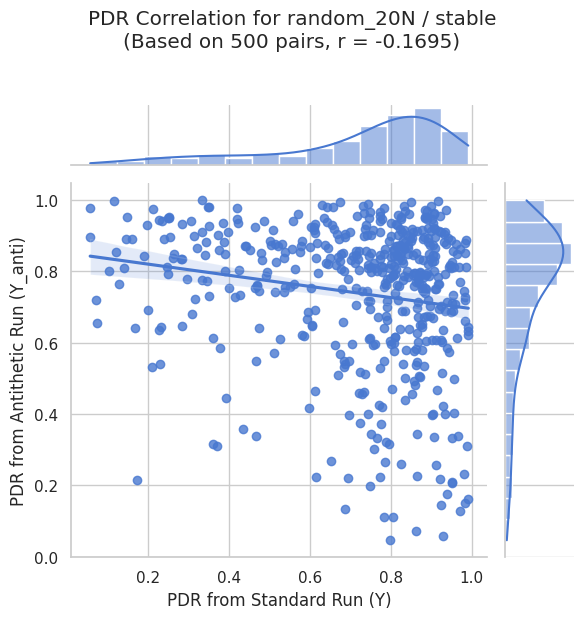



Antithetic analysis complete.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

PATH_TO_RESULTS_BATCH_FOLDER = Path("/home/damole/Documents/develop/SPE-project/results/batch_20251113_09-10-05/")


# Log file names
PDR_LOG_FILE = "log_PDR.csv"
LATENCY_LOG_FILE = "log_e2eLat.csv"

sns.set(style="whitegrid", palette="muted")
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

def process_pdr_file(file_path):

    try:
        df_pdr = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_pdr.empty:

            return 0.0 
        
        if 'delivered' not in df_pdr.columns:
            print(f"  - ERROR: 'delivered' column not found in: {file_path}", file=sys.stderr)
            return None
            
        # The 'delivered' column is 0 or 1. The mean is the PDR.
        run_pdr = df_pdr['delivered'].mean()
        return run_pdr
    
    except FileNotFoundError:
        print(f"  - WARNING: PDR file not found, skipping: {file_path}", file=sys.stderr)
        return None
    except pd.errors.EmptyDataError:
        # File exists but is empty. Treat as PDR 0.0
        return 0.0
    except Exception as e:
        print(f"  - ERROR processing PDR file {file_path}: {e}", file=sys.stderr)
        return None


if not PATH_TO_RESULTS_BATCH_FOLDER.is_dir():
    print(f"ERROR: Batch directory not found at: {PATH_TO_RESULTS_BATCH_FOLDER}", file=sys.stderr)
    print("Please check your 'PATH_TO_RESULTS_BATCH_FOLDER' variable.", file=sys.stderr)
else:
    print(f"Starting Antithetic Correlation Analysis for: {PATH_TO_RESULTS_BATCH_FOLDER.name}\n")
    
    # Find topology folders
    topo_dirs = sorted([d for d in PATH_TO_RESULTS_BATCH_FOLDER.iterdir() if d.is_dir()])
    
    if not topo_dirs:
        print(f"  No topology folders found in {PATH_TO_RESULTS_BATCH_FOLDER}", file=sys.stderr)

    # --- Iterate over each Topology ---
    for topo_dir in topo_dirs:
        
        # Find channel folders (e.g., 'stable', 'lossy')
        channel_dirs = sorted([d for d in topo_dir.iterdir() if d.is_dir()])
        
        if not channel_dirs:
            print(f"  No channel folders found in {topo_dir}", file=sys.stderr)
            continue
            
        # --- Iterate over each Channel Configuration ---
        for channel_dir in channel_dirs:
            config_name = f"{topo_dir.name} / {channel_dir.name}"
            print("="*70)
            print(f"Processing Configuration: {config_name}")
            print("="*70)

            # --- Find pairs ---
            all_run_dirs = [d for d in channel_dir.iterdir() if d.is_dir()]
            
            # Find all standard runs (names are just digits)
            standard_run_dirs = sorted(
                [d for d in all_run_dirs if d.name.isdigit()],
                key=lambda x: int(x.name)
            )
            
            if not standard_run_dirs:
                print("  No standard seed runs (e.g., '12345') found. Cannot find pairs.")
                continue

            pdrs_standard = []
            pdrs_antithetic = []
            
            print(f"  Found {len(standard_run_dirs)} standard runs. Searching for pairs...")

            # --- Iterate over each Standard Run to find its partner ---
            for std_run_dir in standard_run_dirs:
                std_seed = std_run_dir.name
                anti_partner_name = f"{std_seed}_antithetic"
                anti_run_dir = channel_dir / anti_partner_name
                
                # Check if the antithetic partner exists
                if not anti_run_dir.is_dir():
                    print(f"  - WARNING: Found run {std_seed} but missing partner '{anti_partner_name}'. Skipping pair.", file=sys.stderr)
                    continue
                
                # --- We found a valid pair! Process both files ---
                pdr_file_std = std_run_dir / PDR_LOG_FILE
                pdr_file_anti = anti_run_dir / PDR_LOG_FILE
                
                run_pdr_std = process_pdr_file(pdr_file_std)
                run_pdr_anti = process_pdr_file(pdr_file_anti)
                
                # Only add the pair if BOTH files were processed correctly
                if run_pdr_std is not None and run_pdr_anti is not None:
                    pdrs_standard.append(run_pdr_std)
                    pdrs_antithetic.append(run_pdr_anti)
                else:
                    print(f"  - WARNING: Skipping pair for seed {std_seed} due to file error.", file=sys.stderr)

            # --- Analyze and Plot Correlation for this Configuration ---
            if len(pdrs_standard) < 2:
                print(f"\n  Not enough valid pairs found ({len(pdrs_standard)}) to calculate correlation. Need at least 2.")
            else:
                num_pairs = len(pdrs_standard)
                
                # Create a DataFrame to hold the paired data
                df_corr = pd.DataFrame({
                    'Standard_PDR': pdrs_standard,
                    'Antithetic_PDR': pdrs_antithetic
                })
                
                # Calculate the correlation matrix
                corr_matrix = df_corr.corr()
                
                # Get the single correlation value
                correlation = corr_matrix.loc['Standard_PDR', 'Antithetic_PDR']
                
                print("\n" + "-"*30)
                print(f"Correlation Analysis (PDR)")
                print(f"  (Based on {num_pairs} antithetic pairs)")
                print(f"  Correlation (r): {correlation:.6f}")
                print(f"  Mean Standard PDR:   {np.mean(pdrs_standard):.4f}")
                print(f"  Mean Antithetic PDR: {np.mean(pdrs_antithetic):.4f}")
                print(f"  Mean Paired PDR:     {df_corr.mean(axis=1).mean():.4f}")
                print(f"  StdDev Standard PDR:   {np.std(pdrs_standard):.4f}")
                print(f"  StdDev Antithetic PDR: {np.std(pdrs_antithetic):.4f}")
                print(f"  StdDev Paired PDR:     {df_corr.mean(axis=1).std():.4f} <-- This should be smallest!")
                print("-"*30)


                # --- Plot the Correlation ---
                plot = sns.jointplot(
                    data=df_corr, 
                    x='Standard_PDR', 
                    y='Antithetic_PDR', 
                    kind='reg' # 'reg' adds a regression line
                )
                plot.fig.suptitle(f'PDR Correlation for {config_name}\n(Based on {num_pairs} pairs, r = {correlation:.4f})', y=1.03)
                plot.set_axis_labels('PDR from Standard Run (Y)', 'PDR from Antithetic Run (Y_anti)')
                plt.tight_layout()
                plt.show() # Display the plot

        print("\n")

print("="*70)
print("Antithetic analysis complete.")

Starting Antithetic Correlation Analysis for: batch_20251113_21-02-52

Processing Configuration: random_20N / stable
  Found 500 standard runs. Searching for pairs...

------------------------------
Correlation Analysis (PDR)
  (Based on 500 antithetic pairs)
  Correlation (r): -0.061006
  Mean Standard PDR:   0.8308
  Mean Antithetic PDR: 0.8038
  Mean Paired PDR:     0.8173
  StdDev Standard PDR:   0.1629
  StdDev Antithetic PDR: 0.1927
  StdDev Paired PDR:     0.1224 <-- This should be smallest!
------------------------------


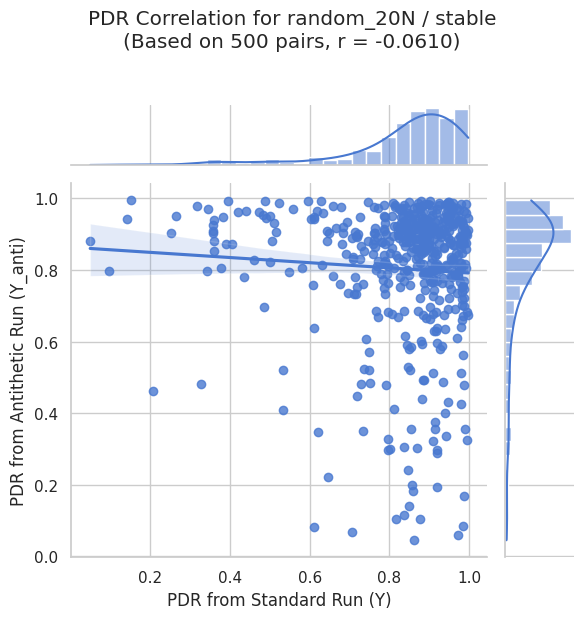



Antithetic analysis complete.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings

PATH_TO_RESULTS_BATCH_FOLDER = Path("/home/damole/Documents/develop/SPE-project/results/batch_20251113_21-02-52/")


# Log file names
PDR_LOG_FILE = "log_PDR.csv"
LATENCY_LOG_FILE = "log_e2eLat.csv"

sns.set(style="whitegrid", palette="muted")
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

def process_pdr_file(file_path):

    try:
        df_pdr = pd.read_csv(file_path, skipinitialspace=True)
        
        if df_pdr.empty:

            return 0.0 
        
        if 'delivered' not in df_pdr.columns:
            print(f"  - ERROR: 'delivered' column not found in: {file_path}", file=sys.stderr)
            return None
            
        # The 'delivered' column is 0 or 1. The mean is the PDR.
        run_pdr = df_pdr['delivered'].mean()
        return run_pdr
    
    except FileNotFoundError:
        print(f"  - WARNING: PDR file not found, skipping: {file_path}", file=sys.stderr)
        return None
    except pd.errors.EmptyDataError:
        # File exists but is empty. Treat as PDR 0.0
        return 0.0
    except Exception as e:
        print(f"  - ERROR processing PDR file {file_path}: {e}", file=sys.stderr)
        return None


if not PATH_TO_RESULTS_BATCH_FOLDER.is_dir():
    print(f"ERROR: Batch directory not found at: {PATH_TO_RESULTS_BATCH_FOLDER}", file=sys.stderr)
    print("Please check your 'PATH_TO_RESULTS_BATCH_FOLDER' variable.", file=sys.stderr)
else:
    print(f"Starting Antithetic Correlation Analysis for: {PATH_TO_RESULTS_BATCH_FOLDER.name}\n")
    
    # Find topology folders
    topo_dirs = sorted([d for d in PATH_TO_RESULTS_BATCH_FOLDER.iterdir() if d.is_dir()])
    
    if not topo_dirs:
        print(f"  No topology folders found in {PATH_TO_RESULTS_BATCH_FOLDER}", file=sys.stderr)

    # --- Iterate over each Topology ---
    for topo_dir in topo_dirs:
        
        # Find channel folders (e.g., 'stable', 'lossy')
        channel_dirs = sorted([d for d in topo_dir.iterdir() if d.is_dir()])
        
        if not channel_dirs:
            print(f"  No channel folders found in {topo_dir}", file=sys.stderr)
            continue
            
        # --- Iterate over each Channel Configuration ---
        for channel_dir in channel_dirs:
            config_name = f"{topo_dir.name} / {channel_dir.name}"
            print("="*70)
            print(f"Processing Configuration: {config_name}")
            print("="*70)

            # --- Find pairs ---
            all_run_dirs = [d for d in channel_dir.iterdir() if d.is_dir()]
            
            # Find all standard runs (names are just digits)
            standard_run_dirs = sorted(
                [d for d in all_run_dirs if d.name.isdigit()],
                key=lambda x: int(x.name)
            )
            
            if not standard_run_dirs:
                print("  No standard seed runs (e.g., '12345') found. Cannot find pairs.")
                continue

            pdrs_standard = []
            pdrs_antithetic = []
            
            print(f"  Found {len(standard_run_dirs)} standard runs. Searching for pairs...")

            # --- Iterate over each Standard Run to find its partner ---
            for std_run_dir in standard_run_dirs:
                std_seed = std_run_dir.name
                anti_partner_name = f"{std_seed}_antithetic"
                anti_run_dir = channel_dir / anti_partner_name
                
                # Check if the antithetic partner exists
                if not anti_run_dir.is_dir():
                    print(f"  - WARNING: Found run {std_seed} but missing partner '{anti_partner_name}'. Skipping pair.", file=sys.stderr)
                    continue
                
                # --- We found a valid pair! Process both files ---
                pdr_file_std = std_run_dir / PDR_LOG_FILE
                pdr_file_anti = anti_run_dir / PDR_LOG_FILE
                
                run_pdr_std = process_pdr_file(pdr_file_std)
                run_pdr_anti = process_pdr_file(pdr_file_anti)
                
                # Only add the pair if BOTH files were processed correctly
                if run_pdr_std is not None and run_pdr_anti is not None:
                    pdrs_standard.append(run_pdr_std)
                    pdrs_antithetic.append(run_pdr_anti)
                else:
                    print(f"  - WARNING: Skipping pair for seed {std_seed} due to file error.", file=sys.stderr)

            # --- Analyze and Plot Correlation for this Configuration ---
            if len(pdrs_standard) < 2:
                print(f"\n  Not enough valid pairs found ({len(pdrs_standard)}) to calculate correlation. Need at least 2.")
            else:
                num_pairs = len(pdrs_standard)
                
                # Create a DataFrame to hold the paired data
                df_corr = pd.DataFrame({
                    'Standard_PDR': pdrs_standard,
                    'Antithetic_PDR': pdrs_antithetic
                })
                
                # Calculate the correlation matrix
                corr_matrix = df_corr.corr()
                
                # Get the single correlation value
                correlation = corr_matrix.loc['Standard_PDR', 'Antithetic_PDR']
                
                print("\n" + "-"*30)
                print(f"Correlation Analysis (PDR)")
                print(f"  (Based on {num_pairs} antithetic pairs)")
                print(f"  Correlation (r): {correlation:.6f}")
                print(f"  Mean Standard PDR:   {np.mean(pdrs_standard):.4f}")
                print(f"  Mean Antithetic PDR: {np.mean(pdrs_antithetic):.4f}")
                print(f"  Mean Paired PDR:     {df_corr.mean(axis=1).mean():.4f}")
                print(f"  StdDev Standard PDR:   {np.std(pdrs_standard):.4f}")
                print(f"  StdDev Antithetic PDR: {np.std(pdrs_antithetic):.4f}")
                print(f"  StdDev Paired PDR:     {df_corr.mean(axis=1).std():.4f} <-- This should be smallest!")
                print("-"*30)


                # --- Plot the Correlation ---
                plot = sns.jointplot(
                    data=df_corr, 
                    x='Standard_PDR', 
                    y='Antithetic_PDR', 
                    kind='reg' # 'reg' adds a regression line
                )
                plot.fig.suptitle(f'PDR Correlation for {config_name}\n(Based on {num_pairs} pairs, r = {correlation:.4f})', y=1.03)
                plot.set_axis_labels('PDR from Standard Run (Y)', 'PDR from Antithetic Run (Y_anti)')
                plt.tight_layout()
                plt.show() # Display the plot

        print("\n")

print("="*70)
print("Antithetic analysis complete.")